In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import multiprocessing
import math
import time
from tqdm import tqdm
from datetime import datetime 

# Load Dataset

In [3]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [4]:
def readDataset(image_path):
    num_processes = 16
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(process_image, image_path)
    return results

def process_image(image_path):
    im = cv2.imread(image_path)
    # gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(im, (32, 32), interpolation=cv2.INTER_AREA)
    return resized

def load_dataset(train_image, train_label):
    train_image = readDataset(train_image)
    train_image = np.array(train_image)
    train_image = train_image/float(255)
    train_image -= np.mean(train_image)
    train_label = np.array(train_label)
    return (train_image, train_label)


def read_dataset(img_filename):
    filename = []
    label = []
    with open(img_filename, 'r') as f:
        for line in f.readlines():
            s = line.split(' ')
            filename.append(s[0])
            label.append(int(s[1]))
    dataset = []
    for i in range(len(filename)):
        dataset.append((filename[i],label[i]))   
    random.shuffle(dataset)    
    return dataset

In [5]:
dataset_train = read_dataset('train.txt')
dataset_test = read_dataset('test.txt')
dataset_val  = read_dataset('val.txt')

image_paths_train, Y_train = zip(*dataset_train)
image_paths_test, Y_test = zip(*dataset_test)
image_paths_val, Y_val = zip(*dataset_val)

(x_train, y_train) = load_dataset(image_paths_train, Y_train)
(x_test, y_test)   = load_dataset(image_paths_test, Y_test)
(x_valid, y_valid) = load_dataset(image_paths_val, Y_val)
x_train -= np.mean(x_train)
x_valid -= np.mean(x_valid)
x_test -= np.mean(x_test)

In [6]:
# TensorDataset
x_train = torch.FloatTensor(x_train)
x_valid = torch.FloatTensor(x_valid)
x_test = torch.FloatTensor(x_test)
x_train = x_train.permute(0, 3, 1, 2)
x_valid = x_valid.permute(0, 3, 1, 2)
x_test = x_test.permute(0, 3, 1, 2)

y_train = torch.IntTensor(y_train)
y_valid = torch.IntTensor(y_valid)
y_test = torch.IntTensor(y_test)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

In [7]:
print(x_train.shape)

torch.Size([63325, 3, 32, 32])


In [8]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=2048, shuffle=True)
test_dataloader  = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
valid_dataloader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Define Model

In [9]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.activ11 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.activ12 = nn.Sigmoid()
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.activ21 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.activ22 = nn.Sigmoid()
        self.fc1 = nn.Linear(16*5*5, 120)
        self.activ31 = nn.Tanh()
        self.fc2 = nn.Linear(120, 84)
        self.activ32 = nn.Tanh()
        self.fc3 = nn.Linear(84, 50)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activ11(self.conv1(x))
        x = self.activ12(self.pool1(x))
        x = self.activ21(self.conv2(x))
        x = self.activ22(self.pool2(x))
        x = x.view(x.size(0), -1)
        x = self.activ31(self.fc1(x))
        x = self.activ32(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [10]:
def gt_accuracy(predictions, labels):
    correct = torch.eq(predictions, labels).sum().item()
    accuracy = correct / labels.size(0) * 100
    return accuracy

def train(model, train_dataloader, valid_dataloader, loss_fcn, optimizer, n_epochs):
    train_loss_list, train_acc_list = [], []
    val_loss_list, val_acc_list = [], []

    for epoch in range(n_epochs):
        train_loss, val_loss = 0.0, 0.0
        train_acc, val_acc = 0.0, 0.0

        model.train()
        with tqdm(total=len(train_dataloader)) as pbar:
            for imgs, labels in train_dataloader:
                imgs, labels = imgs.to(device), labels.type(torch.LongTensor).to(device)
                optimizer.zero_grad()
                outputs = model(imgs)
                preds = torch.argmax(outputs, dim=1)
                train_acc += gt_accuracy(preds, labels)
                loss = loss_fcn(outputs, labels)
                train_loss += loss
                loss.backward()
                optimizer.step()
                pbar.update(1)

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        if epoch % 1 == 0:
            print(f"Epoch: {epoch + 1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} %")

        model.eval()
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.type(torch.LongTensor).to(device)
                val_prob = model(X)
                val_pred = torch.argmax(val_prob, dim=1)
                val_loss += loss_fcn(val_prob, y)
                val_acc += gt_accuracy(val_pred, y)

            val_loss /= len(valid_dataloader)
            val_acc /= len(valid_dataloader)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            print(f"Epoch: {epoch + 1} | Valid loss: {val_loss:.4f} | Valid acc: {val_acc:.4f} %")

    return (train_loss_list, val_loss_list), (train_acc_list, val_acc_list)

### select device : GPU or CPU

In [11]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(f"Training on {device}.")

Training on cuda:1.


## Start Training

In [12]:
model = LeNet5().to(device)
EPOCHS = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

start_time = time.time()
loss_data, acc_data = train(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    loss_fcn=criterion,
    optimizer=optimizer,
    n_epochs=EPOCHS
)

end_time = time.time()

# calculate the total training time
total_time = end_time - start_time

# calculate the average time per epoch
avg_time_per_epoch = total_time / len(acc_data[0])

print(f'Total training time: {total_time:.2f} seconds')
print(f'Average time per epoch: {avg_time_per_epoch:.2f} seconds')

100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 16.50it/s]


Epoch: 1 | Train loss: 3.9120 | Train acc: 1.9143 %
Epoch: 1 | Valid loss: 3.9117 | Valid acc: 1.7578 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 37.69it/s]


Epoch: 2 | Train loss: 3.9119 | Train acc: 1.9497 %
Epoch: 2 | Valid loss: 3.9113 | Valid acc: 1.7578 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 37.17it/s]


Epoch: 3 | Train loss: 3.9107 | Train acc: 2.4029 %
Epoch: 3 | Valid loss: 3.9080 | Valid acc: 2.9297 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 40.15it/s]


Epoch: 4 | Train loss: 3.9022 | Train acc: 3.4755 %
Epoch: 4 | Valid loss: 3.8966 | Valid acc: 4.1016 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 37.22it/s]


Epoch: 5 | Train loss: 3.8949 | Train acc: 4.4832 %
Epoch: 5 | Valid loss: 3.8945 | Valid acc: 4.2969 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 41.05it/s]


Epoch: 6 | Train loss: 3.8900 | Train acc: 4.9918 %
Epoch: 6 | Valid loss: 3.8902 | Valid acc: 4.2969 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 37.62it/s]


Epoch: 7 | Train loss: 3.8860 | Train acc: 5.5580 %
Epoch: 7 | Valid loss: 3.8893 | Valid acc: 5.0781 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 37.38it/s]


Epoch: 8 | Train loss: 3.8826 | Train acc: 6.0097 %
Epoch: 8 | Valid loss: 3.8818 | Valid acc: 6.4453 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 37.94it/s]


Epoch: 9 | Train loss: 3.8804 | Train acc: 6.0570 %
Epoch: 9 | Valid loss: 3.8825 | Valid acc: 5.8594 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 41.15it/s]


Epoch: 10 | Train loss: 3.8777 | Train acc: 6.3996 %
Epoch: 10 | Valid loss: 3.8796 | Valid acc: 6.8359 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 38.20it/s]


Epoch: 11 | Train loss: 3.8759 | Train acc: 6.6418 %
Epoch: 11 | Valid loss: 3.8815 | Valid acc: 5.0781 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 37.40it/s]


Epoch: 12 | Train loss: 3.8743 | Train acc: 6.8168 %
Epoch: 12 | Valid loss: 3.8818 | Valid acc: 5.0781 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 39.75it/s]


Epoch: 13 | Train loss: 3.8747 | Train acc: 6.7145 %
Epoch: 13 | Valid loss: 3.8787 | Valid acc: 6.2500 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 36.30it/s]


Epoch: 14 | Train loss: 3.8722 | Train acc: 7.0151 %
Epoch: 14 | Valid loss: 3.8822 | Valid acc: 6.0547 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 36.26it/s]


Epoch: 15 | Train loss: 3.8698 | Train acc: 7.4032 %
Epoch: 15 | Valid loss: 3.8765 | Valid acc: 6.4453 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 40.35it/s]


Epoch: 16 | Train loss: 3.8678 | Train acc: 7.5550 %
Epoch: 16 | Valid loss: 3.8728 | Valid acc: 6.6406 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 36.38it/s]


Epoch: 17 | Train loss: 3.8669 | Train acc: 7.6309 %
Epoch: 17 | Valid loss: 3.8705 | Valid acc: 7.0312 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 36.14it/s]


Epoch: 18 | Train loss: 3.8655 | Train acc: 7.8103 %
Epoch: 18 | Valid loss: 3.8699 | Valid acc: 7.0312 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 40.34it/s]


Epoch: 19 | Train loss: 3.8647 | Train acc: 7.9061 %
Epoch: 19 | Valid loss: 3.8684 | Valid acc: 7.8125 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 36.48it/s]


Epoch: 20 | Train loss: 3.8629 | Train acc: 8.1146 %
Epoch: 20 | Valid loss: 3.8672 | Valid acc: 7.0312 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 37.31it/s]


Epoch: 21 | Train loss: 3.8620 | Train acc: 8.1189 %
Epoch: 21 | Valid loss: 3.8677 | Valid acc: 8.5938 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 40.29it/s]


Epoch: 22 | Train loss: 3.8633 | Train acc: 7.9985 %
Epoch: 22 | Valid loss: 3.8682 | Valid acc: 7.8125 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 37.27it/s]


Epoch: 23 | Train loss: 3.8602 | Train acc: 8.2941 %
Epoch: 23 | Valid loss: 3.8607 | Valid acc: 8.3984 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 37.15it/s]


Epoch: 24 | Train loss: 3.8589 | Train acc: 8.4653 %
Epoch: 24 | Valid loss: 3.8428 | Valid acc: 15.2344 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 37.12it/s]


Epoch: 25 | Train loss: 3.8580 | Train acc: 8.5626 %
Epoch: 25 | Valid loss: 3.8517 | Valid acc: 8.0078 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 40.71it/s]


Epoch: 26 | Train loss: 3.8563 | Train acc: 8.8568 %
Epoch: 26 | Valid loss: 3.8497 | Valid acc: 8.9844 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 37.47it/s]


Epoch: 27 | Train loss: 3.8563 | Train acc: 8.7231 %
Epoch: 27 | Valid loss: 3.8595 | Valid acc: 8.2031 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 37.00it/s]


Epoch: 28 | Train loss: 3.8561 | Train acc: 8.7526 %
Epoch: 28 | Valid loss: 3.8605 | Valid acc: 8.0078 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 40.15it/s]


Epoch: 29 | Train loss: 3.8555 | Train acc: 8.8441 %
Epoch: 29 | Valid loss: 3.8535 | Valid acc: 9.1797 %


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 35.77it/s]

Epoch: 30 | Train loss: 3.8546 | Train acc: 8.9059 %
Epoch: 30 | Valid loss: 3.8232 | Valid acc: 14.6484 %
Total training time: 25.92 seconds
Average time per epoch: 0.86 seconds


### Plot the Results

In [13]:
loss_data_train = [t.cpu().item() for t in loss_data[0]]
loss_data_valid = [t.cpu().item() for t in loss_data[1]]

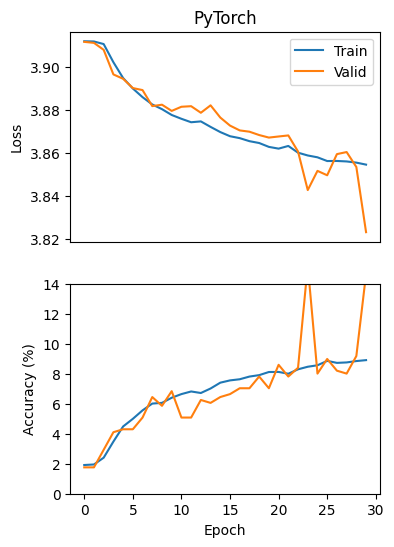

In [14]:
f = plt.figure(figsize=(4,6), dpi=100)
ax = f.add_subplot(211)
plt.title("PyTorch")
plt.plot(loss_data_train)
plt.plot(loss_data_valid)
plt.ylabel("Loss")
plt.xticks([])
plt.legend(['Train', 'Valid'])

ax = f.add_subplot(212)
plt.plot(acc_data[0])
plt.plot(acc_data[1])
# plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim([0, 14])

plt.savefig('./pic/lenet5_torch.png')

# Inference 
accuracy and time

In [1]:
start_time = time.time()
model.eval()
test_acc = 0
with torch.no_grad():
    for X, y in valid_dataloader:
        X, y = X.to(device), y.type(torch.LongTensor).to(device)
        test_prob = model(X)
        test_pred = torch.argmax(test_prob, dim=1)
        test_acc += gt_accuracy(test_pred, y)
    
end_time = time.time()
# calculate the total training time
total_time = end_time - start_time
print(total_time)
print(test_acc /len(test_dataloader))

NameError: name 'time' is not defined

# Profiling Model

In [37]:
from thop import profile

In [38]:
input = torch.randn(1, 3, 32, 32).to(device)
macs, params = profile(model, inputs=(input, ))
print()
print(f"FLOPs: {macs/1e6} GFLOPs, params: {params/1e6} G")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.

FLOPs: 0.655229 MFLOPs, params: 0.065406 M
